In [1]:
import joblib
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    average_precision_score
)
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import StratifiedShuffleSplit


In [2]:
data = joblib.load("titanic_full_preprocessing.pkl")

df_clean = data["df_clean"]
X_train = data["X_train"]
X_test = data["X_test"]
y_train = data["y_train"]
y_test = data["y_test"]
preprocessor = data["preprocessor"]
X_train_processed = data["X_train_processed"]
X_test_processed = data["X_test_processed"]

In [3]:
# Initialize models (with random_state for reproducibility)
logreg = LogisticRegression(random_state=42)
rf = RandomForestClassifier(random_state=42)
svc = SVC(probability=True, random_state=42)
xgb = XGBClassifier(random_state=42)


In [4]:
# Create a VotingClassifier with soft voting
voting_clf = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('svc', svc),
    ('xgb', xgb)
], voting='soft')


# Soft voting explained :

We’ve got 4 models:

Model 1: Logistic Regression

Model 2: Random Forest

Model 3: SVC

Model 4: XGBoost

**We're asking them:**
**"Do you think this passenger survived?"**

They answer how confident they are:

Let’s say for one passenger, the predictions are:

Model 1 (LogReg): 80% chance they survived

Model 2 (Random Forest): 60% chance they survived

Model 3 (SVC): 75% chance they survived

Model 4 (XGBoost): 85% chance they survived

**Soft voting adds these up:**

Total probability for Survived = 80% + 60% + 75% + 85% = 300%

Total for Not Survived = 20% + 40% + 25% + 15% = 100%

Since the group thinks it's more likely the passenger survived, the ensemble predicts: Survived.

************************************************************

Training Logistic Regression...

 Best parameters for Logistic Regression: {'classifier__C': 1, 'classifier__solver': 'liblinear'}

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       105
           1       0.78      0.70      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

AUC for Logistic Regression: 0.7799227799227799 



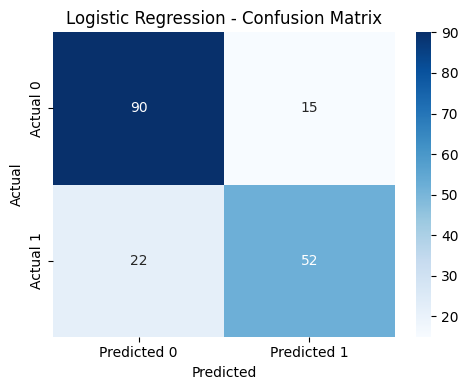


 Precision-Recall AUC: 0.8727549641124561
************************************************************

Training Random Forest...

 Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.82      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

AUC for Random Forest: 0.8077220077220078 



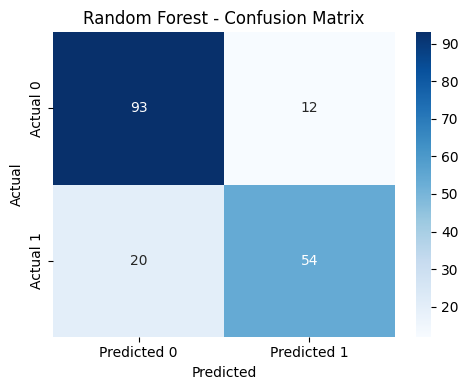


 Precision-Recall AUC: 0.8140933005989724
************************************************************

Training SVC...

 Best parameters for SVC: {'classifier__C': 1, 'classifier__kernel': 'rbf'}

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       105
           1       0.81      0.73      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179

AUC for SVC: 0.802960102960103 



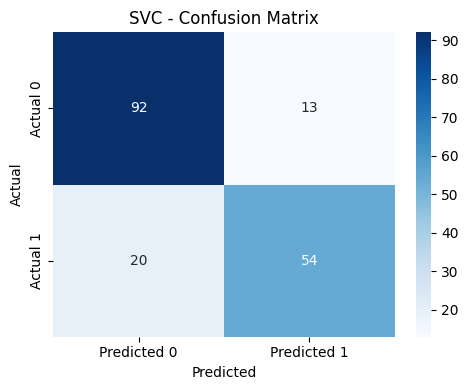


 Precision-Recall AUC: 0.8252607470742612
************************************************************

Training XGBoost...

 Best parameters for XGBoost: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

AUC for XGBoost: 0.8097168597168597 



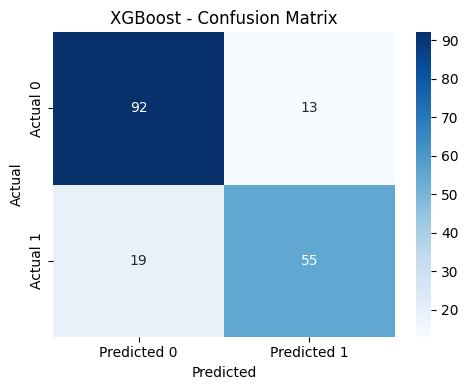


 Precision-Recall AUC: 0.84593177281772


In [5]:
# Hyperparameter tuning for individual models
models = {
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "SVC": svc,
    "XGBoost": xgb
}

# Dictionary to store the best version of each model after hyperparameter tuning
best_models = {}

# Cross-validation strategy : StratifiedKFold for better class balance during cross-validation (best when we have class imbalance which is the case here)
cv_strategy = StratifiedKFold(n_splits=5) # 5 folds

# Iterate over models, apply preprocessing, train, and evaluate
for model_name, model in models.items():
    print("*" * 60)
    print(f"\nTraining {model_name}...")

    # Create a pipeline with preprocessing and model
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

    # Hyperparameter tuning with GridSearchCV
    if model_name == "Logistic Regression":
        param_grid = {"classifier__C": [0.1, 1, 10], "classifier__solver": ["liblinear"]}                 #A custom hyperparameters grid for each model
    elif model_name == "Random Forest":
        param_grid = {"classifier__n_estimators": [50, 100, 200], "classifier__max_depth": [None, 10, 20]}
    elif model_name == "SVC":
        param_grid = {"classifier__C": [0.1, 1, 10], "classifier__kernel": ["linear", "rbf"]}
    elif model_name == "XGBoost":
        param_grid = {"classifier__learning_rate": [0.01, 0.1, 0.3], "classifier__n_estimators": [50, 100, 200]}

    # Set up GridSearchCV with StratifiedKFold
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv_strategy, scoring="accuracy")
    grid_search.fit(X_train, y_train)

    # Store the best model
    best_models[model_name] = grid_search.best_estimator_

    # Evaluate the model
    print(f"\n Best parameters for {model_name}: {grid_search.best_params_}\n")
    y_pred = grid_search.predict(X_test)   # Prediction on "new" data
    y_proba = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search, "predict_proba") else None    # Probability %

    print(classification_report(y_test, y_pred))
    print(f"AUC for {model_name}: {roc_auc_score(y_test, y_pred)} \n")

    # Plot confusion matrix as a heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # PR-AUC is even better than ROC-AUC when the positive class is rare
    if y_proba is not None:
        print(f"\n Precision-Recall AUC: {average_precision_score(y_test, y_proba)}")

# What each metric means :

**Precision (class 1 - survived):** Out of all people the model predicted as survivors, what % actually survived.

**Recall (class 1):** Out of all actual survivors, what % did the model catch.

**F1-score (class 1):** Mean of precision and recall (a good overall measure when both false positives and false negatives matter).

**Accuracy:** Overall, % of the predictions were correct.

**AUC (ROC):** How well the model is at distinguishing between survivors and non survivors.

**Precision-Recall AUC:** How good the model is at identifying positives (survivors) without being fooled (especially useful when the positive class is important).


| Model                   | Accuracy | AUC (ROC) | PR AUC   | Precision (1) | Recall (1) | F1-score (1) | Best At...                                              |
| ----------------------- | -------- | --------- | -------- | ------------- | ---------- | ------------ | ------------------------------------------------------- |
| **Logistic Regression** | 0.79     | 0.78      | **0.87** | 0.78          | 0.70       | 0.74         | Best at avoiding false alarms when predicting survivors |
| **Random Forest**       | 0.82     | **0.81**  | 0.81     | **0.82**      | 0.73       | 0.77         | Best at getting the most correct predictions overall    |
| **SVC**                 | 0.82     | 0.80      | 0.83     | 0.81          | 0.73       | 0.77         | Very balanced and reliable in general                   |
| **XGBoost**             | **0.82** | **0.81**  | 0.85     | 0.81          | **0.74**   | 0.77         | Best at finding actual survivors without missing many   |


In [7]:
# Train the Voting Classifier
print("\nTraining Voting Classifier...")
voting_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", voting_clf)])
voting_pipeline.fit(X_train, y_train)

# Predict probabilities for AUC calculation
y_pred_proba = voting_pipeline.predict_proba(X_test)[:, 1]  # 1*
voting_auc = roc_auc_score(y_test, y_pred_proba) # 2*
print(f"AUC for Voting Classifier: {voting_auc}")

AUC for Voting Classifier: 0.9034749034749034


**We’ve already calculated AUC for each model, now we’re doing the same for the ensemble to see if combining them leads to a better overall performance.**

1* **T**his asks the trained Voting Classifier to give probabilities for each test sample as follows [probability of class 0, probability of class 1] but we only care about the probability of class 1 (survived) so we extract the second column.

2* **T**his computes the AUC (Area Under the ROC Curve):

This tells us how well the model can distinguish between the two classes.

An AUC of 1.0 means perfect separation, 0.5 means random guessing.

It’s a good metric when dealing with imbalanced classes.

In [8]:

# Stratified sample of 100 rows from X_test preserving class distribution
sss = StratifiedShuffleSplit(n_splits=1, test_size=100, random_state=42)
for sample_idx, _ in sss.split(X_test, y_test):
    unseen_sample = X_test.iloc[sample_idx]
    true_labels = y_test.iloc[sample_idx]

# Predict
predictions = voting_pipeline.predict(unseen_sample)
probabilities = voting_pipeline.predict_proba(unseen_sample)[:, 1]

# Create results DataFrame
results_df = unseen_sample.copy()
results_df["Predicted Class"] = predictions
results_df["Probability (Class 1)"] = probabilities
results_df["True Class"] = true_labels

# Accuracy
accuracy = (predictions == true_labels).mean() * 100
print(results_df)
print(f"\nAccuracy on stratified sample: {accuracy:.2f}%")


     Pclass     Sex   Age  SibSp  Parch     Fare Embarked  IsAlone  \
885       3  female  39.0      0      5  29.1250        Q        0   
231       3    male  29.0      0      0   7.7750        S        1   
286       3    male  30.0      0      0   9.5000        S        1   
849       1  female   NaN      1      0  89.1042        C        0   
44        3  female  19.0      0      0   7.8792        Q        1   
..      ...     ...   ...    ...    ...      ...      ...      ...   
63        3    male   4.0      3      2  27.9000        S        0   
447       1    male  34.0      0      0  26.5500        S        1   
457       1  female   NaN      1      0  51.8625        S        0   
442       3    male  25.0      1      0   7.7750        S        0   
669       1  female   NaN      1      0  52.0000        S        0   

     Predicted Class  Probability (Class 1)  True Class  
885                0               0.227453           0  
231                0               0.289589

Our training set is imbalanced so its best to use Stratified Sampling